In [1]:
from bisect import bisect_left, bisect_right
import numpy as np
import scipy
import crossprob

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style
plt.style.use('seaborn-v0_8')

In [11]:
def get_bound(n, c, *, k=0):
    i = np.arange(1, n + 1)
    b = scipy.special.betaincinv(i, n - i + 1, c)
    b[:k] = 0.0
    return b

def berk_jones_bound(n, delta, *, k=0):
    def f(c):
        return crossprob.ecdf1_new_b(get_bound(n, c, k=k)) - (1 - delta)
    
    return get_bound(n, scipy.optimize.bisect(f, 0.0, 1.0), k=k)

def ecdf(xs, data):
    return np.mean(np.expand_dims(data, -1) <= xs, -2)


def get_upper_from_lower(L):
                
    U = np.ones(L.shape)
    no_i = len(L)
    for i in range(no_i-1):
        ind = no_i-i-2
        U[i] = 1-L[ind]
    return U

In [64]:
dist = scipy.stats.fisk(2)
m = 1000
delta = 0.05

['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']


/tmp/ipykernel_1561/3230119720.py:85: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_y_axes().join(ax1, ax2)


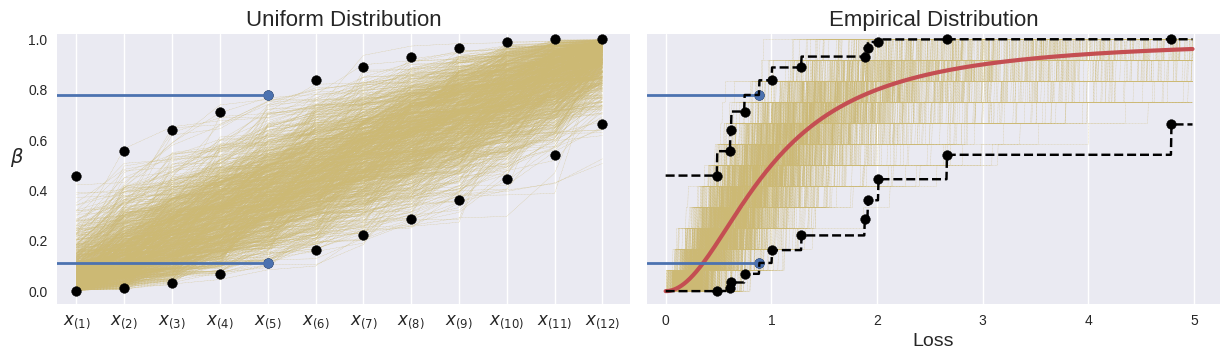

In [66]:
np.random.seed(1234)
color_idx = -8

plt.rcParams["figure.figsize"] = [15., 3.5]
fig, ax = plt.subplots(1, 2)
# pal = sns.color_palette("tab10", 10)
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

print(pal)

ax1 = ax[0]
ax2 = ax[1]

n = 12
X = dist.rvs(n)
X_sorted = np.sort(X, axis=-1)

X_empirical = np.zeros((m,n))
for j in range(m):
    X_empirical[j] = np.sort(dist.rvs(n), axis=-1)

t_max = X_sorted.max()+0.2
t = np.linspace(np.minimum(X_sorted.min(), 0.0), t_max, 1001)

##################################################
##################################################
i = np.arange(1, n + 1)
b = berk_jones_bound(n, delta)
b_padded = np.concatenate([np.zeros(1), b])

u_bound = get_upper_from_lower(b)
u_bound_padded = np.concatenate([u_bound, np.ones(1)])

c1 = pal[4]
c2 = pal[0]
c3 = pal[2]



U = np.random.rand(m, n)
U_sorted = np.sort(U, axis=-1)
for j in range(m):
    ax1.plot(i, U_sorted[j], '--', color=c1, lw=0.2, zorder=1)

ax1.scatter(i, b, color="k", zorder=2, label="$U_{(i)}, l_i$")
ax1.scatter(i, u_bound, color="k", zorder=2, label="$U_{(i)}, u_i$")

ax1.scatter(i[color_idx], b[color_idx], color=c2, zorder=1000)
ax1.plot([0.5,i[color_idx]],[b[color_idx],b[color_idx]], "-", color=c2, linewidth=2.0, zorder=1000)

ax1.scatter(i[color_idx], u_bound[color_idx], color=c2, zorder=1000)
ax1.plot([0.5,i[color_idx]],[u_bound[color_idx],u_bound[color_idx]], "-", color=c2, linewidth=2.0, zorder=1000)

ax1.set_ylim(ymax=1.02)
ax1.set_xticks(i)
ax1.set_xticklabels(["$x_{({" + str(j) + "})}$" for j in i], fontsize=12)
ax1.set_ylabel(r"$\beta$   ", fontsize=14, rotation=0)
ax1.set_xlim(0.5,None)
# ax1.legend(loc="lower right", fontsize=14)

for j in range(m):
    ax2.plot(t,ecdf(t,X_empirical[j]), '--', color=c1, lw=0.2, zorder=1)

ax2.scatter(X_sorted, b, color="k", label="$X_{(i)}, l_i$")
ax2.scatter(X_sorted, u_bound, color="k", label="$X_{(i)}, u_i$")

ax2.scatter(X_sorted[color_idx], b[color_idx], color=c2, zorder=1000)
ax2.plot([-0.175,X_sorted[color_idx]],[b[color_idx],b[color_idx]], "-", color=c2, linewidth=2.0, zorder=1000)

ax2.scatter(X_sorted[color_idx], u_bound[color_idx], color=c2, zorder=1000)
ax2.plot([-0.175,X_sorted[color_idx]],[u_bound[color_idx],u_bound[color_idx]], "-", color=c2, linewidth=2.0, zorder=1000)

ax2.plot(t, dist.cdf(t), label=r"$F$", color=c3, linewidth=3.0, zorder=100)

ax2.plot(t, [b_padded[bisect_left(X_sorted, v)] for v in t], "--", color="k", label="$L$", zorder=1001)
ax2.plot(t, [u_bound_padded[bisect_left(X_sorted, v)] for v in t], "--", color="k", label="$U$", zorder=1001)

ax2.set_ylim(ymax=1.02)
# ax2.set_xlim(-0.175,None)
# ax2.legend(loc="lower right", fontsize=14)
# ax2.set_title("n={}".format(n), fontsize=14)

##################################################
##################################################
ax1.get_shared_y_axes().join(ax1, ax2)
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.set_xlabel("Loss", fontsize=14)

ax1.set_xlim(0.6,None)
ax2.set_xlim(-0.175,None)

ax1.grid(False)
ax2.grid(False)

ax1.grid(axis='x')
ax2.grid(axis='x')
ax1.set_title("Uniform Distribution", fontsize=16)
ax2.set_title("Empirical Distribution", fontsize=16)

sns.despine()
plt.subplots_adjust(wspace=0.03, hspace=0)
plt.savefig("../plots/synthetic/fuq_figure_2.png", dpi=300, bbox_inches="tight")
plt.show()